In [1]:
#hide
from fastbook import *

In the previous chapter we learnt aboout hooks and CAMs and how can we interpret the CNNs using
activation maps.It helps in identifying the areas of the image responsible for model predicting
it to be in particular class.This last and final chapter is a little bit different from others.
We are going to learn new Python terms and libraries here.And we would also implement some 
PyTorch APIs from scratch.Let's start with the final chapter then..

# A fastai Learner from Scratch

As previously mentioned this chapter is a bit different from the previous chapters.It has more 
code and less theory than the previous ones.We would also learn new Python keywords and concepts.
We would implement many fastai and PyTorch API from scratch.At the end we would have our own 
learner class and some callbacks also to train the Imagenette model.We would be creating our 
own model,parameter and DataLoader in plain Pytorch.

Let's start then by downloading and extracting the data..We would be using the Imagenette dataset
which we also used earlier.

## Data

First as usual we would download and extract the dataset using untar_data and store the path of 
the dataset.We will be using the same 160 px Imagenette dataset for our model.

In [2]:
#downloading and extracting the dataset
path = untar_data(URLs.IMAGENETTE_160)

Next to get the image files we use get_image_files and pass the path through it.

In [82]:
#accessing the images using get_image_files
t = get_image_files(path)
t[0]

Path('C:/Users/kruti/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG')

This we can also do using one of the Python's libraries known as glob.It is basically used for
finding pathnames with certain Unix rules.So we first import glob then we pass the expression 
for the pathname to be matched and map it to the path.We store all such filenames in a List type 
object.

In [4]:
#accessing image files using glob
from glob import glob#importing glob
files = L(glob(f'{path}/**/*.JPEG', recursive=True)).map(Path)#passing the expression for the 
#filename to be matched and mapping it to path
files[0]#first image file

Path('C:/Users/kruti/.fastai/data/imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG')

In the source code for get_image_files we have os.walk command.It is fast and more flexible than 
glob.

Let's open one image from the dataset using Python's Imaging Library(PIL).

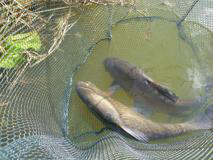

In [5]:
#opening an image using PIL
im = Image.open(files[0])#Opening image using Image class and open method
im

Next we convert the image into tensor by passing it through the tensor and then display the shape
of the tensor.

In [6]:
#converting image into tensor
im_t = tensor(im)#passing image through tensor to get tensor
im_t.shape#shape of the tensor

torch.Size([160, 213, 3])

Now we need to decide what are the dependent variable and Independenr variable.For getting 
dependent variable we can get it by Path.parent from pathlib.Let's first define vocab which 
would contain the list of names of all the categories in classification problem.Thus we get the
list of labels using the parent.name() and to get the vocab we use .unique().

In [7]:
#getting the dependent variables list in vocab
lbls = files.map(Self.parent.name()).unique(); 
lbls

(#10) ['n01440764','n02102040','n02979186','n03000684','n03028079','n03394916','n03417042','n03425413','n03445777','n03888257']

We convert these labels in the vocab to index using l.val2idx which maps the labels with unique
index.It return a dictionary.

In [8]:
#Mapping the labels with index using val2idx()
v2i = lbls.val2idx(); v2i

{'n01440764': 0,
 'n02102040': 1,
 'n02979186': 2,
 'n03000684': 3,
 'n03028079': 4,
 'n03394916': 5,
 'n03417042': 6,
 'n03425413': 7,
 'n03445777': 8,
 'n03888257': 9}

Now as we have the dependent and independent variables separate we can put them together in 
Dataset which we had discussed earlier also.It gives a list of tuples containing the pairs of
dependent and independent variables.

Let's build the Dataset then...

### Dataset

A Dataset is an abstract class in PyTorch and it supports __len__ and __getitem__.len returns the
length of the dataset and getitem returns indexing of the Dataset.

Let's create a dataset for the Imagenette data.

In [9]:
#custom dataset for the Imagenette data
class Dataset:
    def __init__(self, fns): #pass filenames 
        self.fns=fns
    def __len__(self):#returns the length of the dataset
        return len(self.fns)
    def __getitem__(self, i):#returns the pair of dependent and independent variable
        im = Image.open(self.fns[i]).resize((64,64)).convert('RGB')#Open the image using 
        #Python's PIL library
        y = v2i[self.fns[i].parent.name]#get the label using the vocab dictionary 
        return tensor(im).float()/255, tensor(y)#returns the tensor for the image normalized 
        #pixels,the label tensor

We defined the class Dataset and now we need to pass the list of training and validation filename
through the Dataset.Since Imagenette has different folders for training and validation named,
train and valid repsectively.Thus we get the list of files with parent folder named "train" using
list comprehension.Next we store the training  and validation files in different variables and 
see their length.

In [10]:
#Getting filenames for training and validation
train_filt = L(o.parent.parent.name=='train' for o in files)#list of files in training set
train,valid = files[train_filt],files[~train_filt]#getting train and valid file names
len(train),len(valid)#length of training and validation sets.

(9469, 3925)

Now we can pass the train and valid through the Dataset and get the dependent(y) and independent 
variable(x) for first image in training Dataset and display the shape of the image and the label.
The label is a single number item and Image is a 3d tensor.

In [11]:
#passing filenames through the Dataset
train_ds,valid_ds = Dataset(train),Dataset(valid)#getting training and validation datasets
x,y = train_ds[0]#get the image(x) and label index(y)
x.shape,y#3d tensor,label index

(torch.Size([64, 64, 3]), tensor(0, dtype=torch.int32))

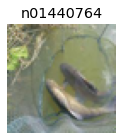

In [12]:
#display the image using show_image with corresponding label indexed in dictionary.
show_image(x, title=lbls[y]);

So dataset returns dependent and independent variables as tuple as we had earlier mentioned.Next
we have to arrange these tuples into mini-batches.This can be done using torch.stack which we 
will use.So we define a function collate through which we pass index range for items in mini-
batch and the dataset.Next using list comprehension we loop through the indexes in the dataset
and get xb and yb.Next we pass xb and yb through torch.stack and return it.

In [13]:
#function for collating into mini-batch
def collate(idxs, ds):#pass the index range and dataset 
    xb,yb = zip(*[ds[i] for i in idxs])#get xb and yb separate from dataset
    return torch.stack(xb),torch.stack(yb)#return stacked dependent(yb) and independent variable

Next we get mini-batch of two items by passing two indexes through collate and the training
dataset(train_ds).It returns stacked x and stacked y.Displaying x's shape shows it is a 4d tensor
.Showing that one of the dimension represents the batch.

In [14]:
#get stacked x and stacked y by calling collate function with two indexes and training dataset
x,y = collate([1,2], train_ds)
x.shape,y#4d tensor and a vector

(torch.Size([2, 64, 64, 3]), tensor([0, 0], dtype=torch.int32))

Now as we have formed a dataset and the batching function also we create DataLoader.It makes the
the data iterable as  mini-batches.We pass dataset,batch size(bs),optional shuffle for training 
set and a ProcessPoolExecutor for preprocessing also in parellel.This is important as opening a 
jPEG image is slow process.The len method returns the length of the batches.Inside the __iter__
we define range of indexes within the dataset.Next we shuffle the indexes if shuffle is True.Next
we divide the indexes into chunks of batches using list comprehension with the passed batch size.
Within the ProcessPoolExecutor we map the collate function and pass the chunks and the dataset 
through it for batching.

In [15]:
#Creating Custom Dataloader 
class DataLoader:
    def __init__(self, ds, bs=128, shuffle=False, n_workers=1):#dataset,batch size,shuffle and n_
        #workers passed
        self.ds,self.bs,self.shuffle,self.n_workers = ds,bs,shuffle,n_workers

    def __len__(self): 
        return (len(self.ds)-1)//self.bs+1#returns number of batches

    def __iter__(self):
        idxs = L.range(self.ds)#list of indexes
        if self.shuffle: #if shuffle is True
            idxs = idxs.shuffle()#shuffle indexes
        chunks = [idxs[n:n+self.bs] for n in range(0, len(self.ds), self.bs)]#list of chunks with
        #indexes in different batches
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, chunks, ds=self.ds)#collating function(chunks and dataset)

Next we pass the training and validation dataset and batch size,shuffle through the DataLoader.
We also grab xb,yb from the first batch in the training dataloader and then display the shape and
length of the xb,yb and length of train_dl.xb is 4d tensor due to batching and yb has 128 integer
labels equal to the batch size.

In [17]:
#Get the training and validation dataloader and xb and yb size
train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=0)#training dataloader(train 
#dataset,batch size,shuffling True)
valid_dl = DataLoader(valid_ds, bs=256, shuffle=False, n_workers=0)#validation dataloader(valid 
#dataset,batch size,shuffling False)
xb,yb = first(train_dl)#get the first batch xb and yb
xb.shape,yb.shape,len(train_dl)#4d tensor,labels,total 74 batches in training 

(torch.Size([128, 64, 64, 3]), torch.Size([128]), 74)

Next for normalization of the images,we first calculate the values on a single mini-batch.

In [18]:
#get the mean standard deviation of the images in Xb.
stats = [xb.mean((0,1,2)),xb.std((0,1,2))]
stats

[tensor([0.4907, 0.4916, 0.4700]), tensor([0.2731, 0.2737, 0.2927])]

We have discussed about Batch Normalization previously and that we use separate layer for the 
same while building CNNs.Here we create the Normalize class and pass the calculated stats through
it.Next in the call we pass the input and test if the input and the stats both are on same device
(CPU/GPU).If they are not we bring them on the same device and then we return the normalized 
image values by subtracting the mean from input and then dividing it by standard deviation.

In [19]:
#custom Normalize class for batch normalization
class Normalize:
    def __init__(self, stats): #pass the calculated stats(mean and std)
        self.stats=stats
    def __call__(self, x):#pass input
        if x.device != self.stats[0].device:#test if input and stats are on same devie
            self.stats = to_device(self.stats, x.device)#if not bring them on same device
        return (x-self.stats[0])/self.stats[1]#input-mean/standard deviation,normalizing the data

Let's see if this custom Normalize class works or not.Thus we pass the stats through Normalize and instantiate the class as norm.This norm now acts as function.Next we define a function tfm_x which takes x,passes it through norm and returns a permuted tensor with axis order changed.

In [20]:
#Normalizing the data
norm = Normalize(stats)#create a Normalize object and pass the stats
def tfm_x(x):#function for normalizing x
    return norm(x).permute((0,3,1,2))#returns normalized x and changing axis order

Next we pass the input batch through the tfm_x and get the normalized tensor as output.

In [21]:
#passing a small batch through the tfm_x for normalization
t = tfm_x(x)
t.mean((0,2,3)),t.std((0,2,3))

(tensor([-0.3186, -0.3754, -0.5033]), tensor([1.0151, 0.9131, 0.7996]))

Now tfm_x normalizes the image but when it returns it permutes the axis that is it changes the 
order of the axis from NHCW to NCHW where N=Batch size,H=height,C=Channels and W=Width.PIL 
represents Image in HWC which cannot work in PyTorch that's why we permute the axis to NCHW.

So now we have loaded our data into DataLoader and also done batch normalization.Let's discuss 
how we would build our model as the data is ready.

## Module and Parameter

Previously also we have used PyTorch's nn.Module and fastai's Module to create the model.We also
would use Parameter class for model.It doesn't perform any special functionality to our model
but only shows about what should be and what not to be included in parameters.It though adds 
requires_grad to the parameters.Below definition of Parameter does this.

In [22]:
#Parameter class for adding requires_grad to the model and decides what to include and what not 
#to
class Parameter(Tensor):
    def __new__(self, x): 
        return Tensor._make_subclass(Parameter, x, True)#creates a subclass 
    def __init__(self, *args, **kwargs): 
        self.requires_grad_()#make requires_grad True for parameter

Inside the Parameter class a special method called "__new__" is defined which adds a new subclass
through _make_subclass method.Next whenever we pass any tensor through parameter it just returns 
a tensor which has requires_grad=True.

In [23]:
#passing tensor through Parameter
Parameter(tensor(3.))

tensor(3., requires_grad=True)

Next we define Module class.

In [24]:
class Module:
    def __init__(self):#pass hook,parameters,children,training mode(boolean)
        self.hook,self.params,self.children,self._training = None,[],[],False
        
    def register_parameters(self, *ps): 
        self.params += ps
    def register_modules   (self, *ms): 
        self.children += ms
        
    @property
    def training(self): return self._training
    @training.setter
    def training(self,v):
        self._training = v
        for m in self.children: m.training=v
            
    def parameters(self):
        return self.params + sum([m.parameters() for m in self.children], [])

    def __setattr__(self,k,v):
        super().__setattr__(k,v)
        if isinstance(v,Parameter): self.register_parameters(v)
        if isinstance(v,Module):    self.register_modules(v)
        
    def __call__(self, *args, **kwargs):
        res = self.forward(*args, **kwargs)
        if self.hook is not None: self.hook(res, args)
        return res
    
    def cuda(self):
        for p in self.parameters(): p.data = p.data.cuda()

The most important thing in the above definition is the definition of parameters.

self.params + sum([m.parameters() for m in self.children], [])

Here any module will return its parameters with the ones for child modules also.The "setattr"
method sets attribute for any class.It uses the Parameter class we defined earlier as attribute.
Anything belonging to that class is the parameter.

The __call__ is used when the object is treated as function.It calls forward and and hook is
defined before calling it.

Module also has cuda and training attributes which we would be discussing later on.

Let's create the first Module, ConvLayer from fastai which we have also used before directly but.
Here we will be defining the contents of it.

In [25]:
#definition for fastai' ConvLayer
class ConvLayer(Module):
    def __init__(self, ni, nf, stride=1, bias=True, act=True):#pass input,output,stride and bias 
        #and activation
        super().__init__()#super call as it's PyTorch
        self.w = Parameter(torch.zeros(nf,ni,3,3))#weight matrix (output X input X 3 X 3)
        self.b = Parameter(torch.zeros(nf)) if bias else None#define bias vector only if bias is 
        #True
        self.act,self.stride = act,stride#activation,stride
        init = nn.init.kaiming_normal_ if act else nn.init.xavier_normal_#type of initialization
        init(self.w)
    
    def forward(self, x):#forward pass
        x = F.conv2d(x, self.w, self.b, stride=self.stride, padding=1)
        #pass convolutional 2d layer
        if self.act: #if activation is true
            x = F.relu(x)#get relu activation
        return x#return the activated input

In the forward we implement 2d Convolution and ReLU activation which is what a ConvLayer is made
of.Before that in init , we initialized the weight matrix and bias vector.We created a small 
class for ConvLayer which also does weight and bias initialization.Let's create a ConvLayer 
object and see the length of parameters(weight and bias).

In [26]:
#creating ConvLayer object
l = ConvLayer(3, 4)
len(l.parameters())#parameters for ConvLayer

2

Finally first we pass the xb through tfm_x to normalize input.Then we pass the normalized input
through the Convlayer(l) and get the shape of the output.The output is 4d tensor.

In [27]:
#Normalizing input and passing it through Convlayer
xbt = tfm_x(xb)#passing xb through tfm_x for normalization
r = l(xbt)#passing the normalized input through the Convlayer
r.shape#shape of the output

torch.Size([128, 4, 64, 64])

Previously we implemented Convlayer let's implement one of the simple layers known as linear 
layer.We follow the same process as in ConvLayer.In init we initializw weights matrix and bias 
vector.We also provide the method of initialization.And in forward we simply return the Wx+b.The
weight is transposed to match the dimensions.

In [28]:
#class definition for Linear layer
class Linear(Module):
    def __init__(self, ni, nf):#pass input feature and output features
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni))#initialize weight
        self.b = Parameter(torch.zeros(nf))#initializer bias vector
        nn.init.xavier_normal_(self.w)#type of initialization
    
    def forward(self, x): #forward pass
        return x@self.w.t() + self.b#return Wx+b

Let's create an object of linear class.Pass a tensor through it and see the output.

In [29]:
#Testing the linear module
l = Linear(4,2)#Instantiating the object of Linear module
r = l(torch.ones(3,4))#passing a tensor through it and see the shape
r.shape

torch.Size([3, 2])

Next we create a test module which checks if multiple parameters are used if all of them are
registered or not.

In [30]:
#Testing module for checking if multiple parameters are registered or not
class T(Module):
    def __init__(self):
        super().__init__()
        self.c,self.l = ConvLayer(3,4),Linear(4,2)#convlayer and linear layer both

Since there are two layers,one convolutional layer and one Linear.So there would be two separate 
sets of parameters for weights and bias.So in total we should have 4 sets.To check we create a 
T module object and see the number of parameters using length of parameters.

In [31]:
#Creating a Test module object
t = T()
len(t.parameters())#No of parameter sets in it 

4

We also call cuda on t object to put all the parameters on GPU.

In [32]:
#putting parameters on GPU
t.cuda()#calling cuda on t object
t.l.w.device#checking device now

device(type='cuda', index=0)

Now that we have explored the inside bits of ConvLayer,Linear module and also about Dataset and
DataLoader.Let's join these to create a simple CNN...

### Simple CNN

CNN that is Convolutional Neural Network is used for Computer vision models.We saw that it 
consists of many layers and a Sequential class is used for combining all the layers to make a 
network.Let's see the definition of a Sequential class..

In [33]:
#Sequential module for implementing the model
class Sequential(Module):
    def __init__(self, *layers):#the list of layers passed
        super().__init__()#super call
        self.layers = layers#layers passed
        self.register_modules(*layers)#register all the modules

    def forward(self, x):#forward pass
        for l in self.layers:#iterate through the layers
            x = l(x)#pass the input through the layer and return the output
        return x#recursive pass

In the forward method we loop through every layer and it is called everytime and output is 
recursively passed.There is one extra register_modules method we defined here.It's important to
register layers else they won't appear in parameters.

Next we create a simple AdaptivePool class which in the forward method pools the output to 1 X 1 
and flattens it by taking mean.

In [34]:
#Adaptive Pool layer for flattening the output
class AdaptivePool(Module):
    def forward(self, x): return x.mean((2,3))

We have defined the Sequential Module and earlier we had also defined Conv layer and linear layer
.Thus we create a simple CNN in the way we had created earlier by joining all the parts we 
defined in this chapter...

In [35]:
#creating a simple cnn network
def simple_cnn():
    return Sequential(
        ConvLayer(3 ,16 ,stride=2), #32 #adding 4 convolutional layer
        ConvLayer(16,32 ,stride=2), #16
        ConvLayer(32,64 ,stride=2), # 8
        ConvLayer(64,128,stride=2), # 4
        AdaptivePool(),#Average pooling layer
        Linear(128, 10)#Linear layer
    )

Let's see if we have the correct set of parameters for each layer.We just create an object and 
call simple_cnn and see the number of parameters in it.

In [36]:
#creating simple cnn object
m = simple_cnn()
len(m.parameters())#no of parameters

10

We had discussed about hooks in the previous chapter.They are the lines of code which can be 
attached with any layer.It can be either passed as a list or we just run it as a simple function.
Below xbt is the normalized input which we pass through the model and while iterating through
layers,we attach the hook with each layer.The function in heek is print_stat which prints the 
output mean and standard deviation for outputs through every layer.

In [37]:
#hook function which prints the statistics for each layer
def print_stats(outp, inp):#input and output passed
    print (outp.mean().item(),outp.std().item())#print output mean and output standard deviation
for i in range(4):#iterating through every layer
    m.layers[i].hook = print_stats#attach the hook to every layer

r = m(xbt)#passing normalized input(xbt) through the model
r.shape #shape of the output

0.5285447835922241 0.8526557683944702
0.4325723946094513 0.8141783475875854
0.4295772910118103 0.7405962347984314
0.45888566970825195 0.7222435474395752


torch.Size([128, 10])

Now we have defined dataloader and the model architecture also.let's try implementing a loss
function now for updating the parameters..

## Loss

The next step is to choose loss function now.Previously we have learnt about many loss functions
such as MSE,MAE,Cross Entropy loss,Negative log likelihood loss and many more.Let'see the 
definition of negative log likelihood.One thing to note is that though it is called Negative Log
Likelihood but there is no log here.

In [66]:
#Negative log likelihood loss 
def nll(input, target):#input and target 
    input=input.long()#Long tensor
    target=target.long()#Long Tensor
    input=torch.Tensor.float(input)
    return -input[range(target.shape[0]), target].mean()#returns the calculated loss

To add log to this we add softmax function here and take a log of it.

To add the log components we define log_softmax function and it applies softmax and then takes 
log of the value.Then we call the log_softmax and pass a number through it.

In [67]:
#Definition for log softmax
def log_softmax(x): 
    return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

sm = log_softmax(r); sm[0][0]#calling log_softmax with a number

tensor(-1.7157, grad_fn=<SelectBackward>)

When we combine negative log likelihood(nll) and log_softmax we get cross-entropy loss.Thus
we call nll with sm(output of log_softmax) and target(yb) and get the loss.

In [68]:
#getting the cross-entropy loss
loss = nll(sm, yb)
loss

tensor(2.0938)

We know about the basic operation of logarithm

log(a/b)=log(a)-log(b)

Thus we can simplify log_softmax further which we had previously defined as `(x.exp()/(x.exp().sum(-1))).log()`:

Using the above basic operation this can be simplified as:-

log(x.exp())-log(x.exp().sum(-1))

which can be further written as:-
    
x-log(x.exp().sum(-1))

Let's implement this in code.

In [69]:
#simplified log_softmax expression
def log_softmax(x): 
    return x - x.exp().sum(-1,keepdim=True).log()#x-log(x.exp().sum(-1))
sm = log_softmax(r); sm[0][0]

tensor(-1.7157, grad_fn=<SelectBackward>)

There is one more way by which this can be simplified known as Log Sum Exponential trick.[LogSumExp](https://en.wikipedia.org/wiki/LogSumExp) trick. It uses following formula:- 

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where $a$ is the maximum of $x_{j}$.

Let's implement this in code using a random tensor and see the result

In [70]:
#Applying the log sum exponent trick 
x = torch.rand(5)#random tensor
a = x.max()#maximum element of the array
x.exp().sum().log() == a + (x-a).exp().sum().log()#applying the formula

tensor(False)

Let's put this into a function so that we can implement it on our data.Thus we create a function
logsumexp which takes x as input and calculates m as maximum and returns the result as the above
formula.

In [71]:
#Applying log sum exponents in function
def logsumexp(x):
    m = x.max(-1)[0]#maximum element
    return m + (x-m[:,None]).exp().sum(-1).log()

logsumexp(r)[0]

tensor(3.1819, grad_fn=<SelectBackward>)

Thus we implement the same trick in log_softmax function and simplify the expression.

In [72]:
#implementing log sum exponents in log_softmax function
def log_softmax(x): 
    return x - x.logsumexp(-1,keepdim=True)

It gives the same result as before.

In [73]:
sm = log_softmax(r); sm[0][0]

tensor(-1.7157, grad_fn=<SelectBackward>)

We know that passing predictions through log_softmax and then passing it through nll along with
targets gives cross entropy loss.We have to take mean of the nll score though.

In [74]:
#cross entropy definition
def cross_entropy(preds, yb):#prediction,targets passed
    return nll(log_softmax(preds), yb).mean() #prediction passed through log_softmax and then 
#passed through nll with targets(yb).mean()

Now we have defined objects for data,model and also loss function now.Now we need something to 
fit the model and update the parameters and an optimizer can do this.Let's then create an
optimizer and a learner then..

## Learner

Previously also we had implemented SGD from scratch.We had also discussed about other optimizers
such as adam,rmsprop as well.Here we will be discussing about SGD which is the simplest so far..
Let's define a class for SGD then.We pass parameters,learning rate and weight decay through it.
While in step method we iterate through all the parameters through for loop and update the 
parameters using gradients and learning rate.Since we have weight decay so we multiply parameter
by that component and add that also to out term and multiply it by learning rate.Next after 
updating each parameter we zero the gradient history otherwise it is added up.

In [75]:
#class for optimizer
class SGD:
    def __init__(self, params, lr, wd=0.):#parameters,learning rate,weight decay passed 
        store_attr()
    def step(self):#stepping the parameters
        for p in self.params:#iterating through parameters
            p.data -= (p.grad.data + p.data*self.wd) * self.lr#updating the parameter
            p.grad.data.zero_()#zero the gradient(remove previous history)

Previously also in most of the chapters we have directly used Learner as they are very easy to
implement.For creating learner we need access to training and validation sets separately which is
done by DataLoaders which stores and allows us to access them separately.So let's create 
DataLoaders.One thing that we won't use any other PyTorch functionality here as DataLoaders only
separates training and validation sets.

In [76]:
#DataLoaders for storing training and validation sets
class DataLoaders:
    def __init__(self, *dls): #pass training dataloader and validation dataloader
        self.train,self.valid = dls

dls = DataLoaders(train_dl,valid_dl)#train_dl and valid_dl

We should not confuse dataloader with DataLoaders.Previously  we had created dataloader for
training and validation datasets which chunks the data into mini-batches whereas DataLoaders just
allow us to access train dataloader(train_dl) and validation dataloader(valid_dl) separately.
Let's create Learner now which basically fits our model.We would pass all the classe we creted
through the Learner class.

In [77]:
#Learner class for fitting the model
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=SGD):#model,dataloaders,loss 
        #function,learning rate,callbacks and optimizer passed
        store_attr()#store all these as attributes
        for cb in cbs: #iterate through callbacks
            cb.learner = self

    def one_batch(self):#batch wise forward pass
        self('before_batch')
        xb,yb = self.batch#get dependent(y) and independent variable(x)
        self.preds = self.model(xb)#pass the input through model to get predictions
        self.loss = self.loss_func(self.preds, yb)#pass predictions,targets(yb) to get losss
        if self.model.training:#check for Training mode
            self.loss.backward()#calculate gradient
            self.opt.step()#update parameters
        self('after_batch')

    def one_epoch(self, train):#each epoch
        self.model.training = train#equal to train if training 
        self('before_epoch')
        dl = self.dls.train if train else self.dls.valid#check for training/validation
        for self.num,self.batch in enumerate(progress_bar(dl, leave=False)):#iterate through bat
            #ches
            self.one_batch()#call this for forward pass
        self('after_epoch')
    
    def fit(self, n_epochs):#fitting the model,number of epochs passed
        self('before_fit')
        self.opt = self.opt_func(self.model.parameters(), self.lr)#set optimizer
        self.n_epochs = n_epochs#number of epochs
        try:
            for self.epoch in range(n_epochs):#iterate through each epoch
                self.one_epoch(True)#call for each epoch
                self.one_epoch(False)
        except CancelFitException: pass#continue
        self('after_fit')
        
    def __call__(self,name):#callback name passed
        for cb in self.cbs:#callbacks 
            getattr(cb,name,noop)()#set it as attribute

One of the largest and most important class we defined in this Chapter is the Learner.But every
method in it is easily undertandable.

The most important method here is fit.We pass number of epochs through fit and at each epoch 
calls self.one_epoch for every train=True and then train=False also.Then self.one_epoch in turn
calls self.one_batch for each batch in dls.train or dls.valid.Finally self.one_batch calculates
gradient and updates the parameter to fit one mini-batch.

Before and after every step,learner calls self which in turns "__call__",a standard Python functionality.It loops through each call back and returns an attribute with each callback name.
This is done in every method.Like "before_fit" and "after_fit","before_epoch" and "after_epoch"
and "before_batch" and "after_batch",everytime "__call__" is called.

Learner uses the standard training loop we discussed earlier,only difference is that it is also
calling some "callbacks".So let's discuss about callbacks then...

### Callbacks

We have discussed about callbacks in fastai before also.Earlier we had directly passed them 
through Learner object with cbs attribute.Here while initializing Learner class,we passed cbs as 
list of callbacks.In Learner.__init__ further we loop through cbs and assign the learner to the 
each callback.

for cb in cbs: cb.learner = self

In other words,every callback knows about the learner it is used in.It's important as callback 
then cannot get information about the learner or modify it's contents.

Getting information from learner is important for "__Callback__" so we make it more easy to do that.We define a class Callback as a subclass of "__GetAttr__" having a default attribute of "learner".

In [78]:
#Get information from learner through Callback class as a subclass of "GetAttr"
class Callback(GetAttr): 
    _default='learner'

"GetAttr" is one of the fastai classes which implements Python's standard "__getattr__" and "__dir__" methods such that if we access any attribute that doesn't exist it passes the callback 
to the object defined as default.

For example,if we need to move all the parameters to GPU in the starting of fit.This can be simply done defining before_fit as self.learner.model.cuda().We thus define a class SetupLearnerCB inherited from Callback which in turn inherits from GetAttr.



In [2]:
#callback for moving the mini-batch and the model parameters to GPU
class SetupLearnerCB(Callback):
    def before_batch(self):#before_batching
        xb,yb = to_device(self.batch)#moving mini-batch to GPU
        self.learner.batch = tfm_x(xb),yb#normalizing the input in the batch

    def before_fit(self): #before fitting
        self.model.cuda()#move model parameters to GPU

In SetupLearnerCB we also define before_batch and move the mini-batch to GPU using to_device(self.batch).We could also use self.learner.batch instead but as we are reading the 
attribute so we can use the short form also.In the next line since we set the attribute so we use
self.learner.batch and pass the normalized input(tfm_x(xb)) and the target(yb).

Next we define before_fit in which we move all our model parameter to GPU by calling self.model.cuda(). 

Before passing the callback let's define one more callback to track the results.It keeps track
of accuracy,loss after every epoch and for every batch.

In [80]:
class TrackResults(Callback):
    def before_epoch(self): self.accs,self.losses,self.ns = [],[],[]
        
    def after_epoch(self):
        n = sum(self.ns)
        print(self.epoch, self.model.training,
              sum(self.losses).item()/n, sum(self.accs).item()/n)
        
    def after_batch(self):
        xb,yb = self.batch
        acc = (self.preds.argmax(dim=1)==yb).float().sum()
        self.accs.append(acc)
        n = len(xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

Now we can use the Learner.We define the list of callbacks(cbs) and create the Learner object 
through which we pass the model,dataloaders,loss function,the learning rate and the callbacks.
Using fit method we fit the model for one epoch.

In [81]:
#passing callbacks through the learner and fitting the model for 1 epoch
cbs = [SetupLearnerCB(),TrackResults()]#callbacks to be passed
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs)#the learner(model,dataloaders
#loss function,learning rate,callbacks) passed
learn.fit(1)#fitting one epoch

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In this chapter since we are applying everything from scratch.So we defined every class from 
scratch here.But in earlier chapter we were able to implement all of this using fastai's classes
in very less code.So fastai creates this much flexiblity.

We had improved our model previously using LRFinder.But previously we were directly calling it.
This time we will be creating it from scratch.

### Scheduling the Learning Rate

To improvise upon our model and improve the results,we choose optimal Learning rate Finder and do
1cycle training.These are termed as annealing callbacks meaning during training the hyperparameters change gradually.Let's define a class for LRFinder..

In [3]:
#Learning rate finder object
class LRFinder(Callback):
    def before_fit(self):#before fitting 
        self.losses,self.lrs = [],[]#losses and learning rates
        self.learner.lr = 1e-6 #initial learning rate
        
    def before_batch(self):
        if not self.model.training: #check if in training mode
            return#else return
        self.opt.lr *= 1.2 #vary learning rate by multiplying by 1.2

    def after_batch(self):
        if not self.model.training:#check for training mode
            return #else return
        if self.opt.lr>10 or torch.isnan(self.loss): #check if learning rate is very high or if
            #loss is null
            raise CancelFitException#raise exception
        self.losses.append(self.loss.item())#add loss to the list of losse
        self.lrs.append(self.opt.lr)#add learning rate to the list of lrs

We use CancelFitException here which is an empty class.It is only used to denote exception.Let's
add LRFinder as a callback to our list of callbacks in the Learner and see the results.We fit the
model for 2 epochs.

In [ ]:
#adding LRFinder as a callback for fitting the model
lrfind = LRFinder()#creating an object for LRFinder
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])#Learner(model
#,dataloaders,loss function,learning rate,callbacks)
learn.fit(2)#fitting the model for 2 epochs

0 True 2.6336045582954903 0.11014890695955222


0 False 2.230653363853503 0.18318471337579617


We have stored learning rates and corresponding losses in lists.We can plot them against each 
other and we make the x-axis log axis as it was in fastai.Let's look at the plot.

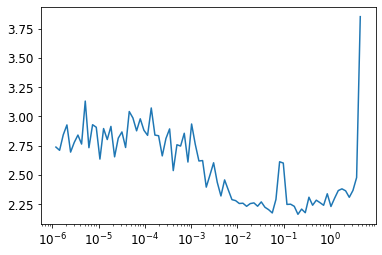

In [ ]:
#plotting learning rates and losses against each other
plt.plot(lrfind.lrs[:-2],lrfind.losses[:-2])
plt.xscale('log')#Making x axis as log axis

We know that 1cycle training uses variable learning rates during the training process.It starts
with a base learning rate then increases it gradually till a maximum point and then again the 
learning rate decreases gradually.Let's implement this using a callback.

In [4]:
#Implementing Onecycle training in class
class OneCycle(Callback):
    def __init__(self, base_lr): #pass base learning rate
        self.base_lr = base_lr
    def before_fit(self): 
        self.lrs = []#store the learning rates in list(before fitting)

    def before_batch(self):
        if not self.model.training: #check for training
            return
        n = len(self.dls.train)#length of training set
        bn = self.epoch*n + self.num #current batch number
        mn = self.n_epochs*n#Total number of passes
        pct = bn/mn
        pct_start,div_start = 0.25,10
        if pct<pct_start:
            pct /= pct_start
            lr = (1-pct)*self.base_lr/div_start + pct*self.base_lr
        else:
            pct = (pct-pct_start)/(1-pct_start)
            lr = (1-pct)*self.base_lr
        self.opt.lr = lr
        self.lrs.append(lr)

In the above callback we vary the learning rate according to specific expressions and at the end
store the learning rate inside the list of learning rates.Let's pass a base learning rate and 
create a OneCycle object and pass it in list of callbacks in Learner.

In [ ]:
#Adding One cycle training as callback
onecyc = OneCycle(0.1)#base learning rate=0.1
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[onecyc])#Learner(model,
#dataloader,loss function,learning rate,callback)

Next we fit the model for some epochs and see the result.

In [ ]:
#hide_output
learn.fit(8)

Finally, we'll check that the learning rate followed the schedule we defined (as you see, we're not using cosine annealing here):

We stored the learning rates in a list so we can access them now.Next we plot the learning rates
and see how they increase first and decrease later during 1cycle training.

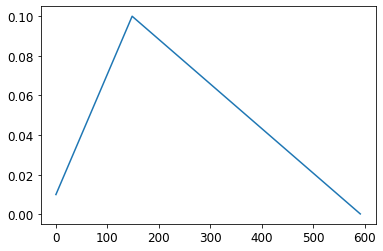

In [ ]:
plt.plot(onecyc.lrs);

## Conclusion

We have explored the key concepts of the fastai library are implemented by re-implementing them in this chapter. Now as we know how  it's built, as a next step we should learn about the intermediate and advanced tutorials in the fastai documentation to learn more about the library.

## Questionnaire

> tip: Experiments: For the questions here that ask you to explain what some function or class is, you should also complete your own code experiments.

1. What is `glob`?
1. How do you open an image with the Python imaging library?
1. What does `L.map` do?
1. What does `Self` do?
1. What is `L.val2idx`?
1. What methods do you need to implement to create your own `Dataset`?
1. Why do we call `convert` when we open an image from Imagenette?
1. What does `~` do? How is it useful for splitting training and validation sets?
1. Does `~` work with the `L` or `Tensor` classes? What about NumPy arrays, Python lists, or pandas DataFrames?
1. What is `ProcessPoolExecutor`?
1. How does `L.range(self.ds)` work?
1. What is `__iter__`?
1. What is `first`?
1. What is `permute`? Why is it needed?
1. What is a recursive function? How does it help us define the `parameters` method?
1. Write a recursive function that returns the first 20 items of the Fibonacci sequence.
1. What is `super`?
1. Why do subclasses of `Module` need to override `forward` instead of defining `__call__`?
1. In `ConvLayer`, why does `init` depend on `act`?
1. Why does `Sequential` need to call `register_modules`?
1. Write a hook that prints the shape of every layer's activations.
1. What is "LogSumExp"?
1. Why is `log_softmax` useful?
1. What is `GetAttr`? How is it helpful for callbacks?
1. Reimplement one of the callbacks in this chapter without inheriting from `Callback` or `GetAttr`.
1. What does `Learner.__call__` do?
1. What is `getattr`? (Note the case difference to `GetAttr`!)
1. Why is there a `try` block in `fit`?
1. Why do we check for `model.training` in `one_batch`?
1. What is `store_attr`?
1. What is the purpose of `TrackResults.before_epoch`?
1. What does `model.cuda` do? How does it work?
1. Why do we need to check `model.training` in `LRFinder` and `OneCycle`?
1. Use cosine annealing in `OneCycle`.

### Further Research

1. Write `resnet18` from scratch (refer to <<chapter_resnet>> as needed), and train it with the `Learner` in this chapter.
1. Implement a batchnorm layer from scratch and use it in your `resnet18`.
1. Write a Mixup callback for use in this chapter.
1. Add momentum to SGD.
1. Pick a few features that you're interested in from fastai (or any other library) and implement them in this chapter.
1. Pick a research paper that's not yet implemented in fastai or PyTorch and implement it in this chapter.
  - Port it over to fastai.
  - Submit a pull request to fastai, or create your own extension module and release it. 
  - Hint: you may find it helpful to use [`nbdev`](https://nbdev.fast.ai/) to create and deploy your package.

# Answers

Ans-1 glob is Python's standard library. It is basically used for finding pathnames with certain Unix rules.So we first import glob then we pass the expression for the pathname to be matched and map it to the path.

Ans-2 Image.open(path to the image)

Ans-3 maps the function to every element in the list object.

Ans-4 Self is used as an instance of the object.Using self we can access the attributes and methods of the class.

Ans-5 It maps the values in the list to corresponding numeric indexes and returns a dictionary.

Ans-6 "__len__" and "__getitem__" are necessary to create Dataset in PyTorch.

Ans-7 We call convert to transform the image into RGB image while opening the image.

Ans-8 ~ is a bitwise operator and refers to NOT.It is used for separating into training and 
validation sets as all the indexes not belonging to training set are validation sets and ~ is used to denote that.

Ans-10 It is used for maintaining the multiple processes in parellel.

Ans-11 It creates a list of range of numbers in the size of dataset.

Ans-12 The __iter__() function returns an iterator for the given object (array, set, tuple etc. or custom objects). 

Ans-13 first keyword is used to get the first element of the corresponding object passed in it.

Ans-14  permute is used for changing the order of axes in the Image tensors.It is because 
.PIL represents Image in HWC which cannot work in PyTorch that's why we permute the axis to NCHW
instead of NHCW.

Ans-15 A function which calls itself while execution is called recursive function.In the parameters method,along with the passed parameters,also returns the  parameters with the ones for child modules also.The "setattr" method sets attribute for any class.It uses the Parameter class we defined earlier as attribute. Anything belonging to that class is the parameter.


Ans-16 def fibonacci(n): 
         return(fibonacci(n-1)+fibonacci(n-2))

Ans-17 super function gives access to the methods and attributes of parent class.It returns an 
object of parent class.

Ans-19 init refers to the type of initialization of the parameters and it depends on wheather 
activations are True or False.

Ans-20 It is important to register the submodules or children modules of the Module class then 
only the information can be passed or accessed.

Ans-22 LogSumExp rule trick is used for simplifying the expression for the log_softmax.

Ans-23 When used for classifiers the log-softmax has the effect of heavily penalizing the model when it fails to predict a correct class.Log axis interpretations also has more theoretical
implications.

Ans-24 "GetAttr" is one of the fastai classes which implements Python's standard "getattr" and "dir" methods such that if we access any attribute that doesn't exist it passes the callback to the object defined as default.

Ans-26 "__call__" is one of the PyTorch's standard functionality.It is used for making classes
which behave as functions.We usually write classes and the instances behave like a function.


Ans-27 get_attr is used for setting the callbacks as attributes.

Ans-28 A try block is used to follow follwing commands and it raises an exception when the 
program cannot execute furher.


Ans-29 It is mandatory to check for training mode so that model can move forward.


Ans-30 store_attr saves the passed arguments in the class as attributes.


Ans-31 To keep a record of the losses and the changes in the accuracy,this callback is used.Inside before_epoch we pass the list of accuracies,losses and the number of iterations/no of
epochs.

Ans-32 Brings the model on GPU making the process more time efficient and space efficient.

Ans-33 Checking of model training in LRFinder and OneCycle is very important as if the model is 
in validation/testing phase then it simply returns.These callbacks change these hyperparameters 
during training phase only.
